In [214]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sms-spam-collection-dataset/spam.csv


In [259]:
df=pd.read_csv('/kaggle/input/sms-spam-collection-dataset/spam.csv',encoding='latin-1')
df

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN


In [260]:
new_df = df[["v1","v2"]]
new_df = new_df.rename(columns = {"v1":"Class","v2":"SMS"})
new_df.head(5)

,Class,SMS
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [261]:
new_df.isna().sum()

Class    0
SMS      0
dtype: int64

In [262]:
new_df.describe()

,Class,SMS
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [263]:
new_df.duplicated().sum()

403

In [264]:
new_df = new_df.drop_duplicates()
new_df.reset_index(drop=True, inplace=True)
new_df

,Class,SMS
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5164,spam,This is the 2nd time we have tried 2 contact u...
5165,ham,Will Ì_ b going to esplanade fr home?
5166,ham,"Pity, * was in mood for that. So...any other s..."
5167,ham,The guy did some bitching but I acted like i'd...


In [265]:
print(new_df['SMS'].str.contains('@').sum()) #contains special characters
print(new_df['SMS'].str.contains('http').sum()) #contains http
print(new_df['SMS'].str.contains('1').sum()) #contains numbers

31
20
622


## 1. Text Cleaning

In [266]:
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import word_tokenize

import spacy

stop_words = set(stopwords.words('english'))

lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r'@\S+', '', text)
    text = re.sub(r'[^\w\s\-]', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'http\S+', '', text)
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct] # tokens and stop words removal
    tokens = [ token for token in tokens if token.strip()]
    return " ".join(tokens)

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [267]:
new_df['SMS'] = new_df['SMS'].apply(clean_text)

In [268]:
# As we can see lot of abbreviations and slangs
new_df['SMS']

0       jurong point crazy available bugis n great wor...
1                                   ok lar joke wif u oni
2       free entry wkly comp win fa cup final tkts st ...
3                                     u dun early hor u c
4                               nah not think go usf live
                              ...                        
5164    nd time try contact u u win å pound prize clai...
5165                             ì b go esplanade fr home
5166                           pity mood soany suggestion
5167    guy bitching act like d interested buy week gi...
5168                                            rofl true
Name: SMS, Length: 5169, dtype: object

## 2. Correcting the spellings and abbreviations

In [180]:
! pip install -q pyspark==3.4.1 spark-nlp==5.3.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 3.6 MB/s eta 0:00:000:00:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 565.0/565.0 kB 11.7 MB/s eta 0:00:0000:01


In [181]:

## References
# https://github.com/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Public/7.Context_Spell_Checker.ipynb
# https://www.johnsnowlabs.com/easily-correcting-typos-and-spelling-errors-on-texts-with-spark-nlp-and-python/

import sparknlp

spark = sparknlp.start() # for GPU training >> sparknlp.start(gpu = True)

from sparknlp.base import *
from sparknlp.annotator import *
from pyspark.ml import Pipeline
import pandas as pd

print("Spark NLP version", sparknlp.version())
print("Apache Spark version:", spark.version)

spark

Spark NLP version 5.3.2
Apache Spark version: 3.4.1


In [182]:
from sparknlp.annotator import *
from sparknlp.common import *
from sparknlp.base import *

from IPython.utils.text import columnize

In [197]:
documentAssembler = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

tokenizer = RecursiveTokenizer()\
    .setInputCols(["document"])\
    .setOutputCol("token")\
    .setPrefixes(["\"", "(", "[", "\n"])\
    .setSuffixes([".", ",", "?", ")","!", "'s"])

spellModel = ContextSpellCheckerModel\
    .pretrained('spellcheck_dl')\
    .setInputCols("token")\
    .setOutputCol("checked")\
    .setErrorThreshold(4.0)\
    .setTradeoff(6.0)

finisher = Finisher()\
    .setInputCols("checked")

pipeline = Pipeline(stages = [
     documentAssembler,
     tokenizer,
     spellModel,
     finisher
  ])

empty_ds = spark.createDataFrame([[""]]).toDF("text")
lp = LightPipeline(pipeline.fit(empty_ds))

spellcheck_dl download started this may take some time.
Approximate size to download 95.1 MB
[OK!]


In [233]:
res = lp.annotate("U dun say so early hor... U c already then say...")
" ".join(res['checked'])

', run say so early or . . . , a already then say . . .'

In [234]:
new_df['cleaned_sms'] = new_df['SMS'].apply(lp.annotate)
new_df['cleaned_sms'] 

0       {'checked': ['during', 'point', 'crazy', 'avai...
1       {'checked': ['oh', 'law', 'joke', 'if', ',', '...
2       {'checked': ['free', 'entry', 'will', 'come', ...
3       {'checked': ['(', 'run', 'early', 'or', 'u', '...
4       {'checked': ['nap', 'not', 'think', 'to', 'use...
                              ...                        
5164    {'checked': ['no', 'time', 'try', 'contact', '...
5165    {'checked': ['ì', ',', 'go', 'Esplanade', 'for...
5166    {'checked': ['city', 'mood', 'many', 'suggesti...
5167    {'checked': ['guy', 'pitching', 'act', 'like',...
5168                        {'checked': ['roll', 'true']}
Name: SMS, Length: 5169, dtype: object

In [248]:
new_df['cleaned_sms'] = new_df['cleaned_sms'].apply(lambda x: x['checked'] if isinstance(x, dict) else [])

In [280]:
new_df['cleaned_sms'] = new_df['cleaned_sms'].apply(lambda x: " ".join(x))

## 3. Recleaning Text

Since the corrections of spellings and abbeviation was implemented, we need to clean texts again.

In [286]:
new_df['cleaned_sms'] = new_df['cleaned_sms'].apply(clean_text)
new_df

,Class,SMS,cleaned_sms
0,ham,jurong point crazy available bugis n great wor...,point crazy available bug great world la e buf...
1,ham,ok lar joke wif u oni,oh law joke
2,spam,free entry wkly comp win fa cup final tkts st ...,free entry come cup final s text receive entry...
3,ham,u dun early hor u c,run early u
4,ham,nah not think go usf live,nap think use live
...,...,...,...
5164,spam,nd time try contact u u win å pound prize clai...,time try contact win å find prize claim east m...
5165,ham,ì b go esplanade fr home,ì esplanade home
5166,ham,pity mood soany suggestion,city mood suggestion
5167,ham,guy bitching act like d interested buy week gi...,guy pitch act like interested buy week free


In [287]:
print(new_df['SMS'][0])
print(new_df['cleaned_sms'][0])

jurong point crazy available bugis n great world la e buffet cine get amore wat
point crazy available bug great world la e buffer line


## TF-IDF Vectorizer

In [291]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [294]:
X = new_df['cleaned_sms']
y= new_df['Class']

tfidf = TfidfVectorizer(stop_words='english', max_features=5000)
X_tfidf=tfidf.fit_transform(X)

In [296]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X_tfidf.toarray(),y,test_size=0.2,random_state=42)

## Models training for Unbalanced Dataset

Class distribution before SMOTE: Counter({0: 3627, 1: 508})


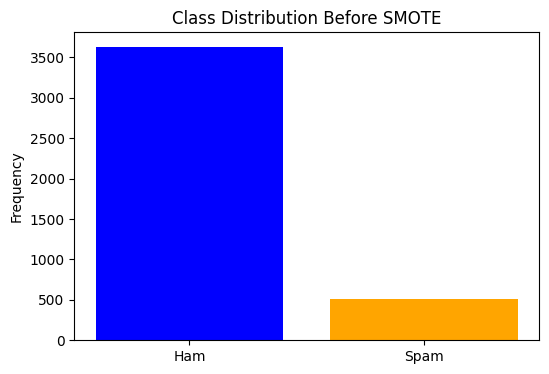

In [303]:
from collections import Counter
import matplotlib.pyplot as plt

y_train_binary = np.array([1 if label == 'spam' else 0 for label in y_train])

original_class_distribution = Counter(y_train_binary)
print("Class distribution before SMOTE:", original_class_distribution)

plt.figure(figsize=(6, 4))
plt.bar(original_class_distribution.keys(), original_class_distribution.values(), color=['blue', 'orange'])
plt.title("Class Distribution Before SMOTE")
plt.xticks([0, 1], ['Ham', 'Spam'])
plt.ylabel("Frequency")
plt.show()

In [305]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

models = {
    "Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(),
    "SVM": SVC()
}

In [321]:
from sklearn.metrics import accuracy_score, classification_report,precision_score, recall_score, f1_score

def models_train(X_train,y_train,X_test_,y_test_,models):
    results = []
    highest_acc = 0
    selected_model = {}
    for name,model in models.items():
        print("Training....",name,"model")
        model.fit(X_train,y_train)
        train_score = model.score(X_train,y_train)
        y_pred_test = model.predict(X_test_)
        acc_test = accuracy_score(y_test_,y_pred_test)
        precision_test = precision_score(y_test_,y_pred_test,average='weighted')
        recall_test = recall_score(y_test_,y_pred_test,average='weighted')
        f1_test = f1_score(y_test_,y_pred_test,average='weighted')
        # print(acc_test,'acc_test')
        if acc_test > highest_acc:
            selected_model[name] = model
        results.append({"Model":name,"Train Score":train_score,"Test Acc":acc_test,"Precision Test":precision_test,"Recall Test":recall_test,
                        "F1 Score Test":f1_test})
        print("Completed\n")
    return results,selected_model

In [309]:
result_unbalance,selected_model = models_train(X_train,y_train,X_test,y_test,models)
result_unbalance = pd.DataFrame(result_unbalance)
result_unbalance

Training.... Naive Bayes model
Completed

Training.... Logistic Regression model
Completed

Training.... SVM model
Completed



,Model,Train Score,Test Acc,Precision Test,Recall Test,F1 Score Test
0,Naive Bayes,0.957437,0.942940,0.945693,0.942940,0.936847
1,Logistic Regression,0.952600,0.940039,0.942303,0.940039,0.933491
2,SVM,0.993229,0.962282,0.963868,0.962282,0.959757


## Models training for Balanced Dataset

Class distribution after SMOTE: Counter({'ham': 3627, 'spam': 3627})


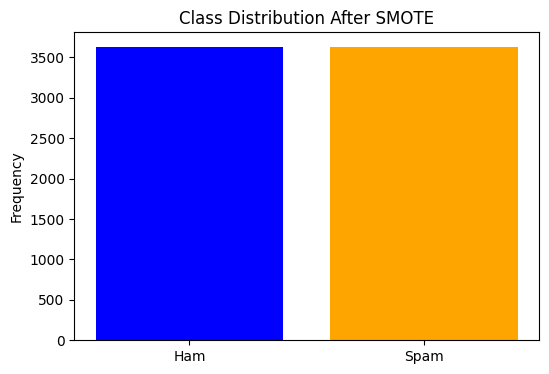

In [318]:
from imblearn.over_sampling import SMOTE


smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

resampled_class_distribution = Counter(y_train_resampled)
print("Class distribution after SMOTE:", resampled_class_distribution)

plt.figure(figsize=(6, 4))
plt.bar(resampled_class_distribution.keys(), resampled_class_distribution.values(), color=['blue', 'orange'])
plt.title("Class Distribution After SMOTE")
plt.xticks([0, 1], ['Ham', 'Spam'])
plt.ylabel("Frequency")
plt.show()

In [325]:
models = {
    "Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(class_weight='balanced'),
    "SVM": SVC(class_weight='balanced')
}

result_balance,selected_model_balance = models_train(X_train_resampled,y_train_resampled,X_test,y_test,models)
result_balance = pd.DataFrame(result_balance)
result_balance

Training.... Naive Bayes model
Completed

Training.... Logistic Regression model
Completed

Training.... SVM model
Completed



,Model,Train Score,Test Acc,Precision Test,Recall Test,F1 Score Test
0,Naive Bayes,0.972429,0.949710,0.956136,0.949710,0.951636
1,Logistic Regression,0.961952,0.959381,0.960185,0.959381,0.959724
2,SVM,0.992832,0.945841,0.943947,0.945841,0.944321
